In [1]:
import sys
sys.path.append("C:/Users/David/Code/AxisID/models")

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageDraw
from collections import OrderedDict
import train
from model import Network
from model_2 import Network as Net2
from model_5 import Network as Net5
from model_6 import Network as Net6
from model_7 import Network as Net7
from model_8 import Network as Net8
import test_model
import shared_functions as f
import random

In [69]:
mod_2 = Net2()
mod_5 = Net5()
mod_6 = Net6()
mod_7 = Net7()
mod_8 = Net8()

print(mod_2.num_parameters())
print(mod_5.num_parameters())
print(mod_6.num_parameters())
print(mod_7.num_parameters())
print(mod_8.num_parameters())

7147
9250
15314
17458
22066


In [8]:
def rescale(weights):
    
    """Rescale a torch.tensor so that it takes values between zero and one
    Args:
        weights: tensor to rescale
    Returns:
        Rescaled weights
    """
    
    maxs = weights.max(dim = -2, keepdim = True)[0].max(dim = -1, keepdim = True)[0]
    mins = weights.min(dim = -2, keepdim = True)[0].min(dim = -1, keepdim = True)[0]
    scale = maxs-mins
    weights = (weights-mins)/scale
    return weights

def visualize_filters(model, n_cols):
    
    """Plot the first layer filters from a model
    Args:
        model: nn.Module
        n_cols: number of columns per row in the plot
    """
    
    modules = []
    
    for module in model.modules():#get all convolutional layers, although we only need first one
        if type(module)==torch.nn.modules.Conv2d:
            modules.append(module)
            
    weights = rescale(modules[0].weight.detach())
    n_filters = weights.shape[0]
    n_channels_in = weights.shape[1]
    n_rows = np.ceil(n_filters/n_cols).astype(dtype = int)
        
    plt.figure(figsize = (2*n_cols, 2*n_rows))
    count = 0
        
    for row in range(n_rows):
        for col in range(n_cols):
                
            try:
                if n_channels_in == 3:
                    data = weights[count].permute((1,2,0))
                else:
                    data = weights[count][0]
            except IndexError:
                break
            
            count+=1
            ax = plt.subplot(n_rows, n_cols, count)
            
            ax.imshow(data)
            ax.set_xticklabels([])
            ax.set_xticks([])
            ax.set_yticklabels([])
            ax.set_yticks([])
            
def read_validation_examples_file(val_examples_path):
    
    """Loads the basenames of examples used in the validation set
    Args:
        val_names_path: path to file contatinin basenames of examples used in validation set
    Returns:
        list of basenames used in the validation set
    """
    
    with open(val_examples_path) as val_examples_file:
        rows = val_examples_file.read().splitlines()
    
    return rows
    
def load_training_results(test_results_path, val_examples_path, img_ext = '.pdf', figsize = (6,4)):
    
    """Loads the results of test_model run on the training set, and plots summary statistics
    Args:
        test_results_path: path to the output of test_model
        val_examples_path: path to file contatinin basenames of examples used in validation set
    Returns:
        list of (image, prediction, value) tuples for training and validation sets
    """
    
    images, predictions, values = test_model.read_results_file(test_results_path)
    val_names = read_validation_examples_file(val_examples_path)
    
    val_results = []
    train_results = []
    
    for image, prediction, value in zip(images, predictions, values):
        if image.split('-')[0] in val_names:
            val_results.append((image, prediction, value))
        else:
            train_results.append((image, prediction, value))
    
    _, train_predictions, train_values = zip(*train_results)
    _, val_predictions, val_values = zip(*val_results)
    
    train_errors = f.circular_difference(np.array(train_predictions), np.array(train_values))
    val_errors = f.circular_difference(np.array(val_predictions), np.array(val_values))
    
    y_lb = 1e-4
    
    rms_error = np.sqrt(np.mean(train_errors**2))
    plt.figure(figsize = figsize)
    plt.hist(np.abs(train_errors), log = True, density = True);
    plt.plot((rms_error, rms_error),(y_lb,1),'--k')
    plt.text(rms_error, 0.5, ' RMS error = '+'{:.1f}'.format(rms_error)+' Degrees', fontsize = 12)
    plt.ylim([y_lb, 1])
    plt.xlim(0,15)
    plt.xticks(fontsize = 14);
    plt.yticks(fontsize = 14);
    plt.ylabel('Probability', fontsize = 15);
    plt.xlabel('Error Magnitude (Degrees)', fontsize = 15);
    plt.title('Training Errors')
    plt.tight_layout()
    plt.savefig('training_errors.'+img_ext)
    
    plt.figure(figsize = figsize)
    rms_error = np.sqrt(np.mean(val_errors**2))
    plt.hist(np.abs(val_errors), log = True, density = True);
    plt.plot((rms_error, rms_error),(y_lb,1),'--k')
    plt.text(rms_error, 0.5, ' RMS error = '+'{:.1f}'.format(rms_error)+' Degrees', fontsize = 12)
    plt.ylim([y_lb, 1])
    plt.xlim(0,15)
    plt.xticks(fontsize = 14);
    plt.yticks(fontsize = 14);
    plt.ylabel('Probability', fontsize = 15);
    plt.xlabel('Error Magnitude (Degrees)', fontsize = 15);
    plt.title('Validation Errors')
    plt.tight_layout()
    plt.savefig('validation_errors.'+img_ext)
    
    print('RMS training error: ', '{:.2f}'.format(np.sqrt(np.mean(train_errors**2))))
    print('RMS validation error: ', '{:.2f}'.format(np.sqrt(np.mean(val_errors**2))))
    
    return train_results, val_results

def load_test_results(test_results_path, img_ext = 'pdf'):
    """Loads the results of test_model run on the test set, and plots summary statistics
    Args:
        test_results_path: path to the output of test_model
    Returns:
        list of (image, prediction, value) tuples for the test set
    """
    
    images, predictions, values = test_model.read_results_file(test_results_path)
    
    
    errors = f.circular_difference(np.array(predictions), np.array(values))
    
    y_lb = 1e-4
    
    rms_error = np.sqrt(np.mean(errors**2))
    hist = plt.hist(np.abs(errors), log = True, density = True);
    plt.plot((rms_error, rms_error),(y_lb,1),'--k')
    plt.text(rms_error, 0.5, ' RMS error = '+'{:.1f}'.format(rms_error)+' Degrees', fontsize = 12)
    plt.ylim([y_lb, 1])
    plt.xlim(0,15)
    plt.xticks(fontsize = 14);
    plt.yticks(fontsize = 14);
    plt.ylabel('Probability', fontsize = 15);
    plt.xlabel('Error Magnitude (Degrees)', fontsize = 15);
    plt.title('Test Errors')
    plt.tight_layout()
    plt.savefig('test_errors.'+img_ext)
    
    return (images, predictions, values), hist

def hexagon_generator(edge_length, offset, theta_offset):
    x, y = offset
    for angle in np.arange(theta_offset, 360+theta_offset, 60):
        x += np.cos(np.pi*angle/180) * edge_length
        y += np.sin(-np.pi*angle/180) * edge_length
        yield x
        yield y

def predict(model, image_path, hex_loc = None, target_size = 256, device = 'cpu'):
    
    """Predict axis orientation with model, and draw the prediction on the image
    Args:
        model: nn.module for prediction
        image_path: path to image
        target_size: image size required for the model
        device: device for prediction
    Returns:
        Model prediction for axis orientation in degrees
    """
    
    image = Image.open(image_path)
    image = test_model.crop_and_scale(image, target_size)
    image = np.array(image)
    
    x = torch.tensor(image.transpose((2,0,1)))
    x = x.unsqueeze(dim = 0)
    x = x.to(device)

    with torch.no_grad():
        prediction = np.array(model(x)[0])
    angle = f.vectoangle(prediction)
    
    if hex_loc:
        image = Image.fromarray(image)
        hexagon = hexagon_generator(32, offset=hex_loc, theta_offset = angle)
        draw = ImageDraw.Draw(image)
        draw.polygon(list(hexagon), outline= 'red')
    
    plt.imshow(image)
    
    return angle

def load_image(image_path, target_size = 256):
    
    image = Image.open(image_path)
    image = test_model.crop_and_scale(image, target_size)
    image = np.array(image)
    
    x = torch.tensor(image.transpose((2,0,1)))
    x = x.unsqueeze(dim = 0)
    
    return x

def normalize(img, eps = 1e-8):
    img = img-img.min()
    img = img/(img.max()+eps)
    return img

def relu(x):
    return x*np.heaviside(x, 0)

def visualize_feature_maps(model, image_path, n_cols = 5, target_size = 256, device = 'cpu', use_relu = True):
    
    """Plot the feature map generated by a given convolutational layer and saves copies
    Args:
        model: nn.module for prediction
        image_path: path to image
        n_cols: number of maps per row
        target_size: image size required for the model
        device: device for prediction
    """
    
    modules = []
    
    for module in model.modules():#get all convolutional layers, although we only need first one
        if type(module)==torch.nn.modules.Conv2d:
            modules.append(module)
    
    activations = {}
    handles = {}

    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook

    for i, module in enumerate(modules):
        handle = module.register_forward_hook(get_activation(i))
        handles[i] = handle
        
    image = Image.open(image_path)
    image = test_model.crop_and_scale(image, 256)
    image = np.array(image)
    
    x = torch.tensor(image.transpose((2,0,1)))
    x = x.unsqueeze(dim = 0)
    x = x.to(device)
    
    prediction = model(x)[0]
    
    for key, activation in activations.items():

        n_filters = activation.shape[1]
        n_rows = np.ceil(n_filters/n_cols).astype(dtype = 'int')

        plt.figure(figsize = (5*n_cols, 5*n_rows))
        count = 0
        for row in range(n_rows):
            for col in range(n_cols):
                count+=1
            
                try:
                    data = activation[0][count-1]
                except IndexError:
                    break
                
                ax = plt.subplot(n_rows, n_cols, count)
                if use_relu:
                    ax.imshow(normalize(relu(data.numpy())), cmap = 'viridis')
                else:
                    ax.imshow(normalize(data.numpy()), cmap = 'viridis')
                ax.set_xticklabels([])
                ax.set_xticks([])
                ax.set_yticklabels([])
                ax.set_yticks([])
        plt.tight_layout()
        plt.savefig('maps-'+str(key)+'.png')
    
    for key, handle in handles.items():
        handle.remove()
        
    return activations

def calculate_baseline(annotation_dir_1, annotation_dir_2, img_ext = 'pdf'):
    """Calculate human baseline based on labelling test examples twice
    Args:
        annotation_dir_1: path to initial labelling of examples
        annotation_dir_2: path to second labelling of examples
    Returns:
        errors between labelling passes
    """
    annotations_1 = os.listdir(annotation_dir_1)
    annotations_1 = [annotation for annotation in annotations_1 if annotation.endswith('-edges.csv')]

    annotations_2 = os.listdir(annotation_dir_2)
    annotations_2 = [annotation for annotation in annotations_2 if annotation.endswith('-edges.csv')]

    angle_1s =[]
    angle_2s =[]

    for annotation_1 in annotations_1:
        basename = annotation_1.split('-')[0]
        angle_1 = test_model.read_annotation_file(annotation_dir_1, basename)
        angle_2 = test_model.read_annotation_file(annotation_dir_2, basename)
        angle_1s.append(angle_1)
        angle_2s.append(angle_2)
    
    errors = f.circular_difference(np.array(angle_1s), np.array(angle_2s))
    y_lb = 1e-4
    
    rms_error = np.sqrt(np.mean(errors**2))
    hist = plt.hist(np.abs(errors), log = True, density = True);
    plt.plot((rms_error, rms_error),(y_lb,1),'--k')
    plt.text(rms_error, 0.5, ' RMS error = '+'{:.1f}'.format(rms_error)+' Degrees', fontsize = 12)
    plt.ylim([y_lb, 1])
    plt.xlim(0,15)
    plt.xticks(fontsize = 14);
    plt.yticks(fontsize = 14);
    plt.ylabel('Probability', fontsize = 15);
    plt.xlabel('Error Magnitude (Degrees)', fontsize = 15);
    plt.title('Baseline Errors')
    plt.tight_layout()
    plt.savefig('baseline_errors.'+img_ext)
    
    return errors, hist

RMS training error:  1.04
RMS validation error:  1.70


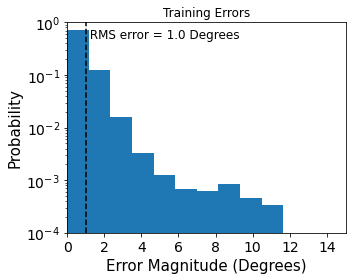

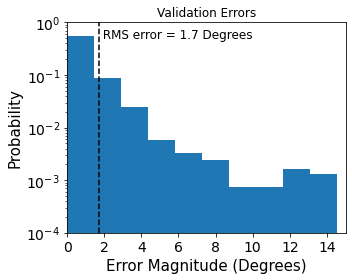

In [6]:
validation_examples_path = 'results/model_6_run_4/validation_examples.txt'
training_results_path = 'results/model_6_run_4/test_results-final.csv'
train_results, val_results = load_training_results(training_results_path, validation_examples_path, img_ext = 'svg',
                                                  figsize = (5,4))

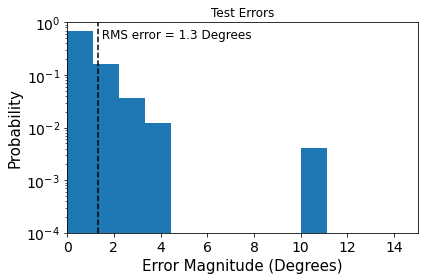

In [7]:
test_results_path = 'results/model_6_run_4/test_set_results-final.csv'
test_results, test_hist = load_test_results(test_results_path, img_ext = 'svg')

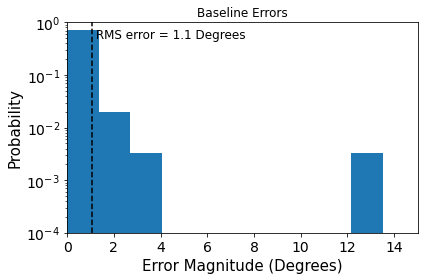

In [8]:
test_annotations_1 = 'test/test_annotations'
test_annotations_2 = 'test/test_annotations_redo'
baseline_errors, base_hist = calculate_baseline(test_annotations_1, test_annotations_2, img_ext = 'svg')

In [9]:
errors = f.circular_difference(np.array(test_results[1]), np.array(test_results[2]))
np.array(test_results[0])[abs(errors)>8]

array(['Jane_hbn1106c34_39.jpg'], dtype='<U49')

In [29]:
model = Net6()
device = 'cpu'
model.to(device)
model_path = 'results/model_6_run_4/model_weights-final.pth'
model.load_state_dict(torch.load(model_path))
model.eval();

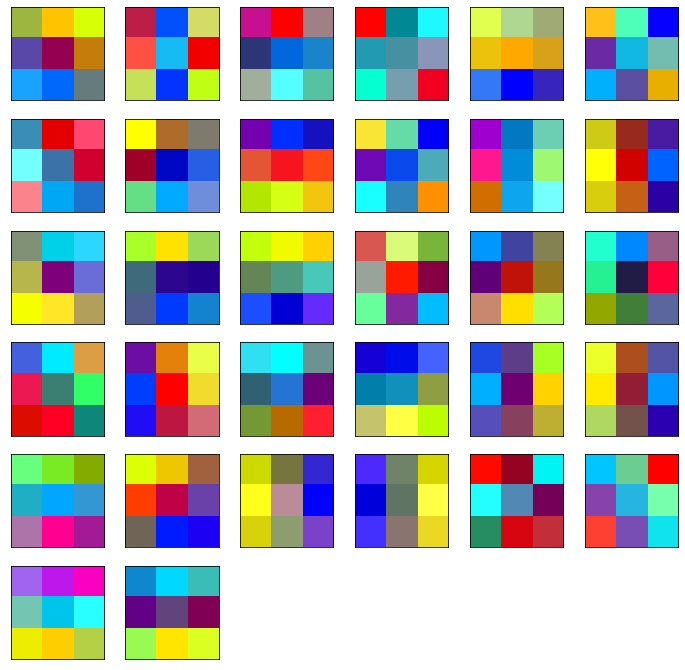

In [30]:
visualize_filters(model, 6)

In [26]:
val_names, val_predictions, val_angles = zip(*val_results)
val_names = np.array(val_names)
val_predictions = np.array(val_predictions)
val_angles = np.array(val_angles)
hard_examples = np.arange(len(val_names))[f.circular_difference(val_predictions, val_angles)>12]

('190609_BN_chip2_04_100x_Stack111-10.tif', 17.69, 18.3)
Predicted Angle:  17.75
True Angle:  18.30


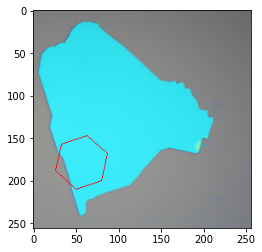

In [27]:
n = 500
example = val_results[n]
print(example)
image_dir = 'images'
image_path = image_dir+'/'+example[0]
prediction = predict(model, image_path, hex_loc= (50,210))
print('Predicted Angle: ', '{:.2f}'.format(prediction))
print('True Angle: ', '{:.2f}'.format(example[2]))

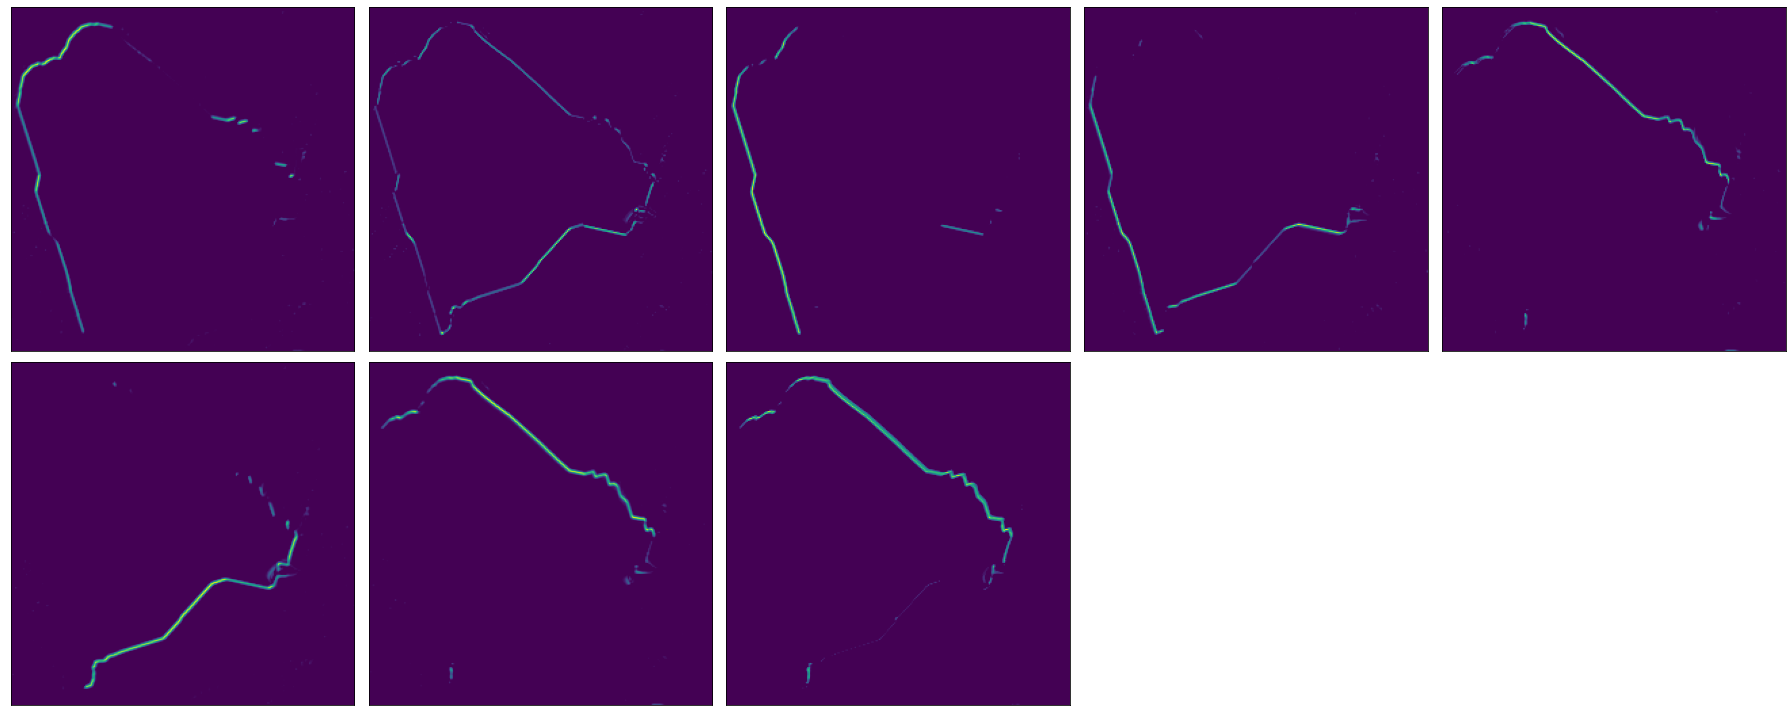

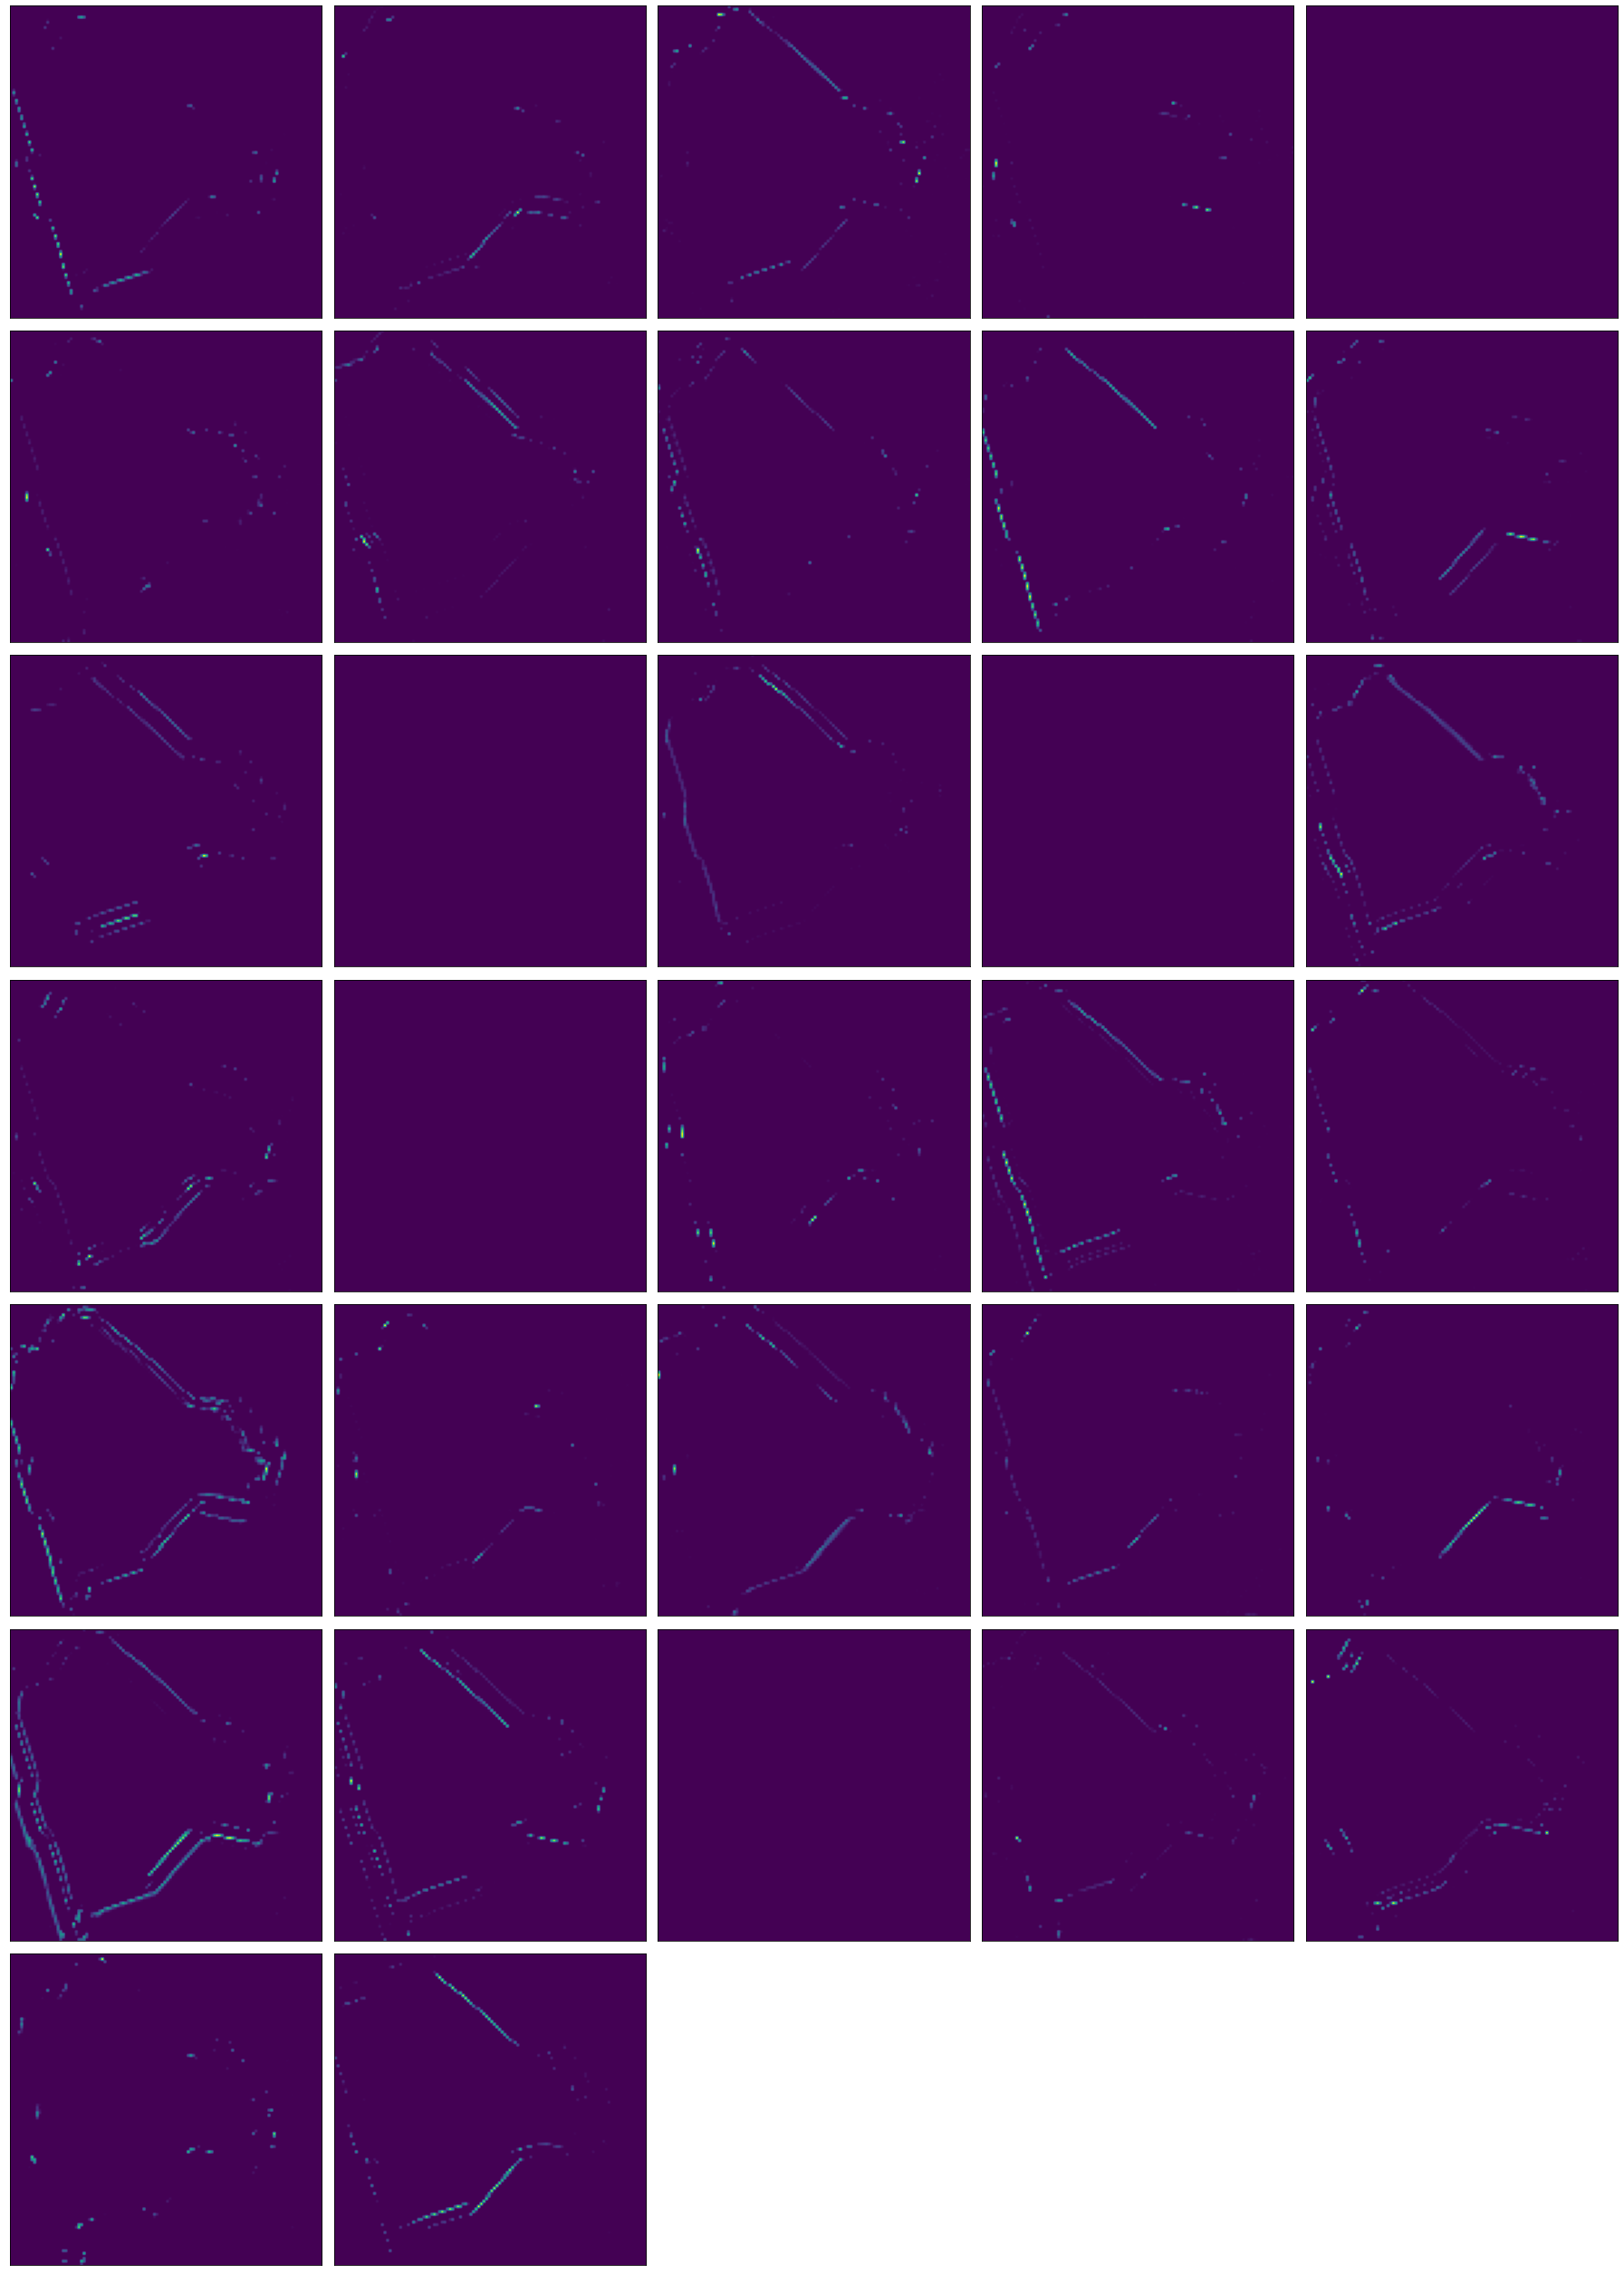

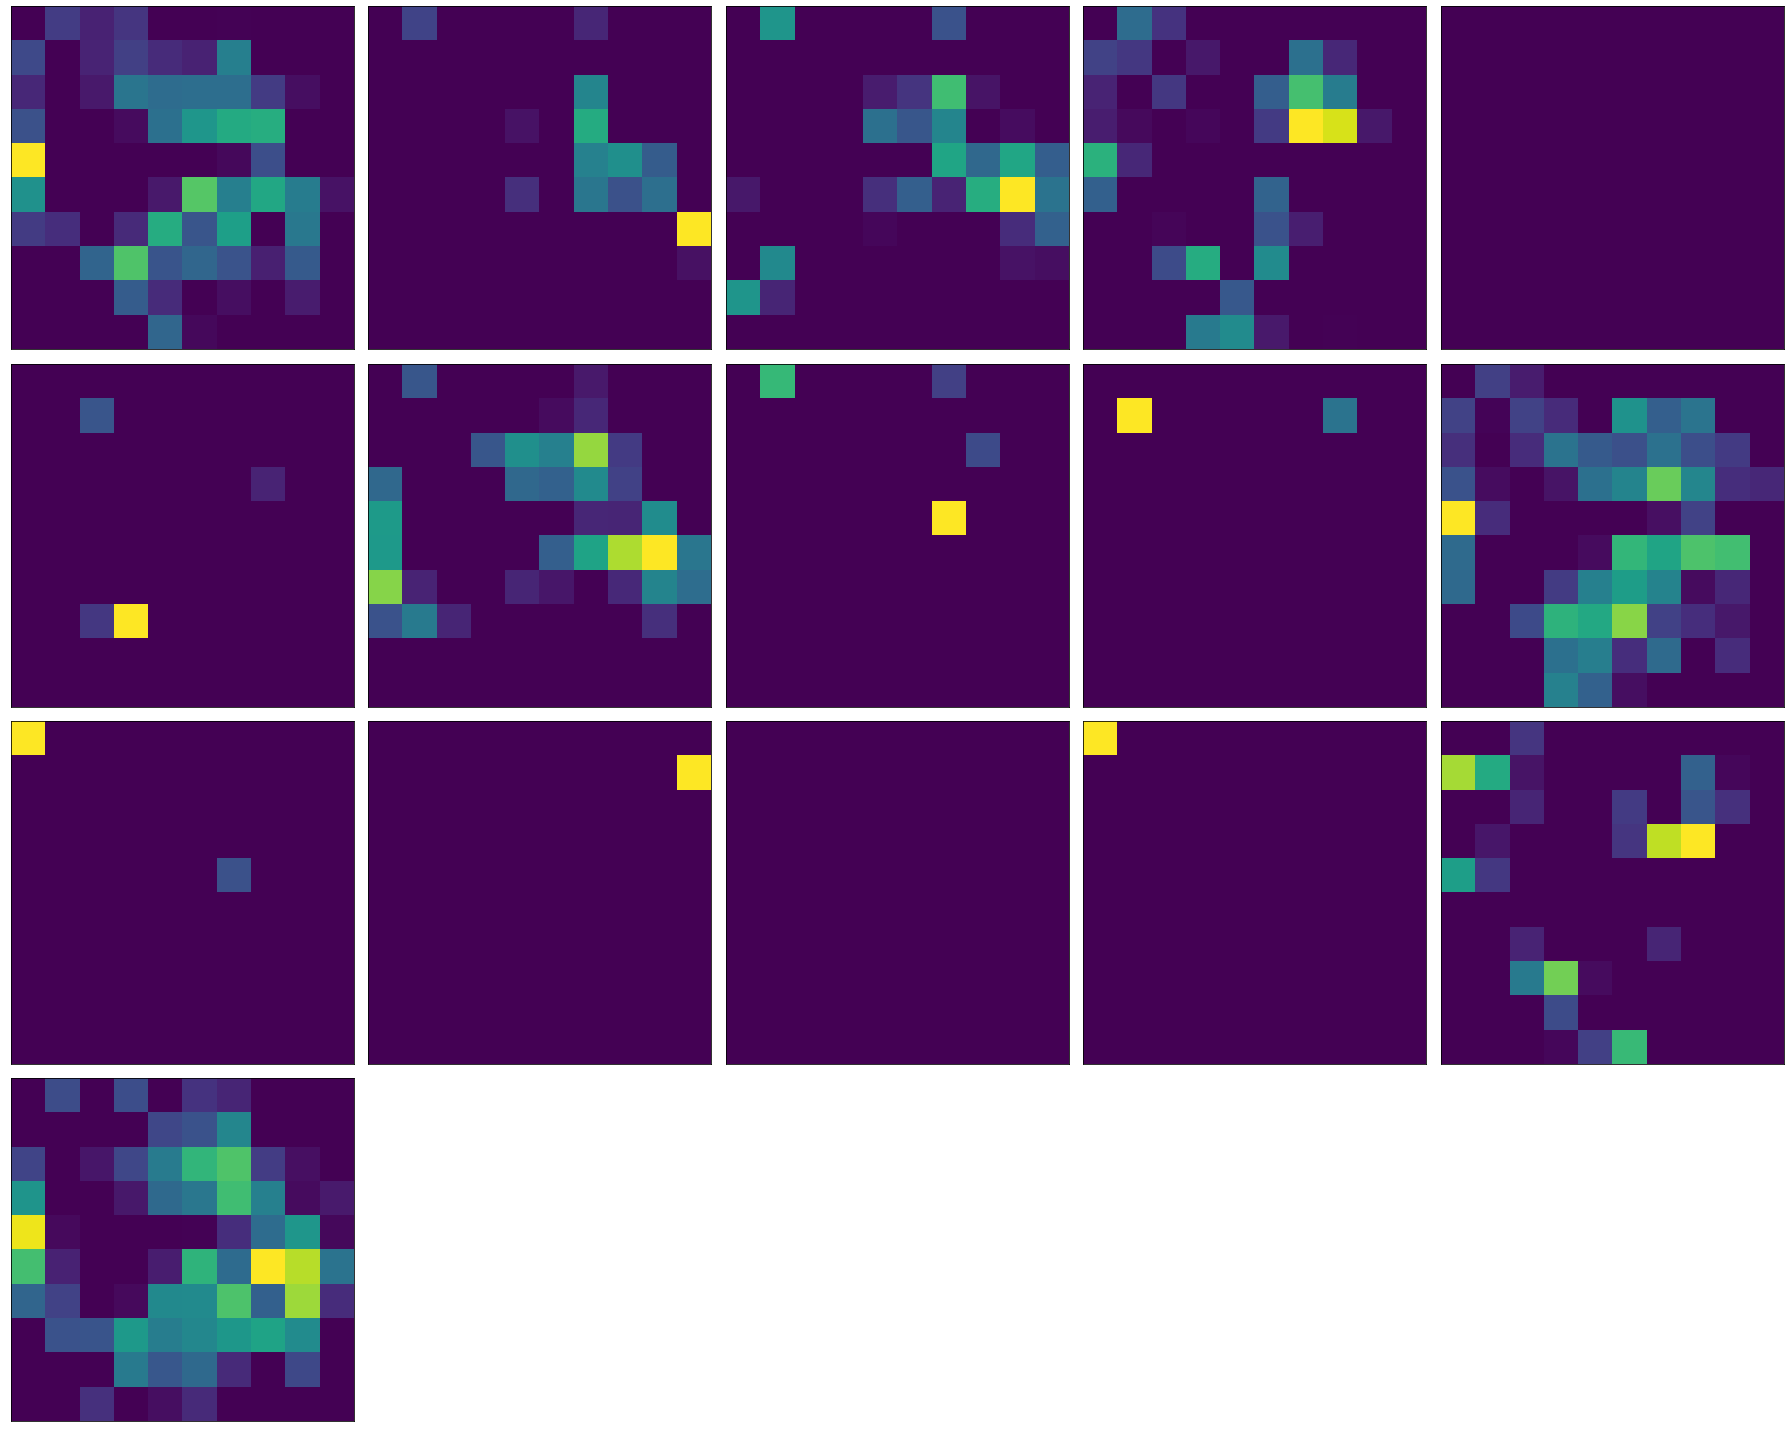

In [28]:
activations = visualize_feature_maps(model, image_path)

In [69]:
parameter_numbers = np.array([7147, 9250, 15314, 17458, 22066])
validation_performance = np.array([2.75, 2.36, 2.06, 2.24, 2.13])
training_performance = np.array([2.38, 1.76, 1.32, 1.65, 1.27])

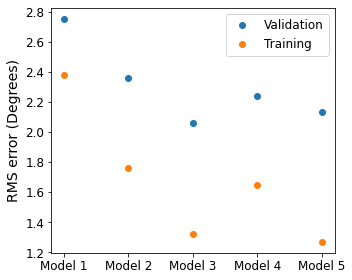

In [141]:
plt.figure(figsize = (5,4))
plt.plot(np.arange(1,6),validation_performance, 'o')
plt.plot(np.arange(1,6),training_performance, 'o')
plt.xticks([1,2,3,4,5]);
plt.ylabel('RMS error (Degrees)', fontsize = 14)
plt.yticks(fontsize = 12)
plt.legend(['Validation', 'Training'], fontsize = 12)
ax = plt.gca()
ax.set_xticklabels(['Model 1','Model 2','Model 3','Model 4', 'Model 5'], fontsize = 12);
plt.tight_layout()
plt.savefig('model_performance.svg')

In [108]:
losses_1 = np.loadtxt('results/model_2_run_2/losses.csv', delimiter = ',')
losses_2 = np.loadtxt('results/model_5_run_1/losses.csv', delimiter = ',')
losses_3 = np.loadtxt('results/model_6_run_1/losses.csv', delimiter = ',')
losses_4 = np.loadtxt('results/model_7_run_1/losses.csv', delimiter = ',')
losses_5 = np.loadtxt('results/model_8_run_1/losses.csv', delimiter = ',')

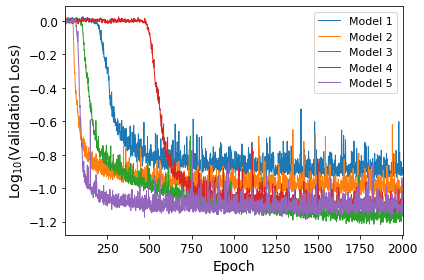

In [140]:
plt.figure(figsize = (6,4))
plt.plot(np.arange(1,2001,1),np.log10(losses_1[:,2]), linewidth = 1.0)
plt.plot(np.arange(1,2001,1),np.log10(losses_2[:,2]), linewidth = 1.0)
plt.plot(np.arange(1,2001,1),np.log10(losses_3[:,2]), linewidth = 1.0)
plt.plot(np.arange(1,2001,1),np.log10(losses_4[:,2]), linewidth = 1.0)
plt.plot(np.arange(1,2001,1),np.log10(losses_5[:,2]), linewidth = 1.0)
plt.legend(['Model 1','Model 2','Model 3','Model 4','Model 5'], fontsize = 11)
plt.xlim([1,2001])
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Log$_{10}$(Validation Loss)', fontsize = 14)
plt.xticks(fontsize = 12);
plt.yticks(fontsize = 12);
plt.tight_layout()
plt.savefig('model_training.svg')

In [145]:
losses_3_1clr = np.loadtxt('results/model_6_run_4/losses.csv', delimiter = ',')

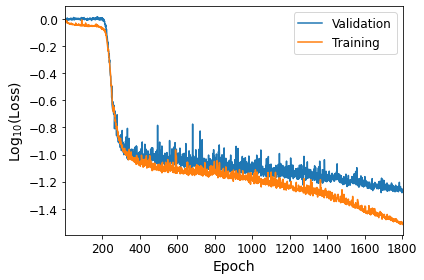

In [154]:
plt.figure(figsize = (6,4))
plt.plot(np.arange(1,1802,1), np.log10(losses_3_1clr[:,2]))
plt.plot(np.arange(1,1802,1), np.log10(losses_3_1clr[:,1]))
plt.xlim(1,1801)
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Log$_{10}$(Loss)', fontsize = 14)
plt.xticks(fontsize = 12);
plt.yticks(fontsize = 12);
plt.legend(['Validation','Training'], fontsize = 12)
plt.tight_layout()
plt.savefig('model_3_training.svg')

In [195]:
steps_up = 800
steps_down = 800
steps_final = 200
init_lr = 1e-4
max_lr = 1e-3
final_lr = 1e-5
min_beta1 = 0.85
init_beta1 = 0.95
beta2 = 0.99
lr = init_lr
beta1 = init_beta1
epochs = 1801

lrs = []
beta1s = []

for epoch in range(epochs):
    
    lrs.append(lr)
    beta1s.append(beta1)
    
    if epoch<steps_up:
        lr += (max_lr-init_lr)/steps_up
        beta1 += (min_beta1-init_beta1)/steps_up
    elif epoch >= steps_up and epoch < steps_down+steps_up:
        lr -= (max_lr-init_lr)/steps_down
        beta1 -= (min_beta1-init_beta1)/steps_down
    elif epoch >= steps_down+steps_up and epoch < steps_down+steps_up+steps_final:
        lr -= (init_lr-final_lr)/steps_final

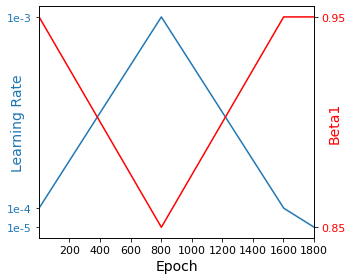

In [246]:
left_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
right_color = 'red'

plt.figure(figsize = (5,4))
plt.plot(np.arange(1,1802),lrs, color= left_color)
plt.xlim(1,1801)
plt.xlabel('Epoch', fontsize = 14)
plt.xticks(fontsize = 11)
plt.yticks([1e-5,1e-4,1e-3],fontsize = 11)
plt.ylabel('Learning Rate', fontsize = 14, color = left_color)
ax_lr = plt.gca()
ax_lr.yaxis.set_label_coords(-0.05,0.5)
ax_lr.set_yticklabels(['1e-5','1e-4','1e-3'])
ax_lr.tick_params(axis = 'y', labelcolor = left_color)
ax_beta = ax_lr.twinx()
ax_beta.plot(np.arange(1,1802), np.array(beta1s), color = right_color)
plt.yticks([0.85,0.95],fontsize = 11)
ax_beta.tick_params(axis = 'y', labelcolor = right_color)
plt.ylabel('Beta1',  fontsize = 14, color = right_color)
ax_beta.yaxis.set_label_coords(1.05,0.5)
plt.tight_layout()
plt.savefig('optimizer_params.svg')